In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, mean_squared_error
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
import scipy

In [2]:
train = pd.read_csv("./data/data_prepared/train_hydraulic_multi.csv", sep=",")
test = pd.read_csv("./data/data_prepared/test_hydraulic_multi.csv", sep=",")

In [3]:
test[test["Risk Level"] == "high"]

,Unnamed: 0.1,Unnamed: 0,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,...,Max_Humidity,Avg_Humidity,Min_Precipitation,Max_Precipitation,Avg_Precipitation,Max_Raindetection,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq,Risk Level
15,2482,2482,T06,2017-04-18T05:40:00+00:00,1687.4,1504.1,1634.5,43.7,56.0,69,...,66.0,64.0,0.0,0.0,0.0,0.0,108.0,111.0,409.0,high
24,869,869,T06,2017-04-07T00:50:00+00:00,1760.4,1601.3,1681.5,25.1,64.0,108,...,66.0,64.0,0.0,0.0,0.0,0.0,108.0,111.0,409.0,high
27,1847,1847,T06,2017-04-13T19:50:00+00:00,1268.5,1235.8,1248.5,5.6,55.0,57,...,66.0,64.0,0.0,0.0,0.0,0.0,108.0,111.0,409.0,high
45,2065,2065,T06,2017-04-15T08:10:00+00:00,128.5,30.0,81.2,31.4,24.0,27,...,66.0,64.0,0.0,0.0,0.0,0.0,108.0,111.0,409.0,high
48,2586,2586,T06,2017-04-18T23:00:00+00:00,1690.2,1553.4,1640.9,29.2,59.0,85,...,66.0,64.0,0.0,0.0,0.0,0.0,108.0,111.0,409.0,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31407,2353,2353,T06,2017-04-17T08:10:00+00:00,1591.4,1332.8,1520.8,52.4,45.0,61,...,66.0,64.0,0.0,0.0,0.0,0.0,108.0,111.0,409.0,high
31410,49,49,T06,2017-04-01T08:10:00+00:00,1254.2,255.6,474.2,372.2,38.0,52,...,66.0,64.0,0.0,0.0,0.0,0.0,108.0,111.0,409.0,high
31422,1399,1399,T06,2017-04-10T17:10:00+00:00,1742.7,1618.0,1680.4,21.1,69.0,112,...,66.0,64.0,0.0,0.0,0.0,0.0,108.0,111.0,409.0,high
31426,1940,1940,T06,2017-04-14T11:20:00+00:00,1370.5,252.8,497.8,387.6,28.0,31,...,66.0,64.0,0.0,0.0,0.0,0.0,108.0,111.0,409.0,high


In [4]:
class_target_name = "Risk Level"
drop_cols = [class_target_name, "Turbine_ID", "Timestamp", "Unnamed: 0", "index_y", "Unnamed: 0.1"]

In [19]:
def get_redundant_pairs(X_train: pd.DataFrame) -> set:
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = X_train.columns
    for i in range(0, X_train.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(X_train: pd.DataFrame, thresholds=[0.5]) -> list:
    au_corr = X_train.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(X_train)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    au_corrs = []
    for threshold in thresholds:
        au_corrs.append(au_corr[au_corr > threshold])
    return au_corrs

def get_indexes_to_drop(corr_df: pd.DataFrame, X_train: pd.DataFrame, y_train: pd.DataFrame) -> set:

    indexes_to_drop = set()
    le = LabelEncoder()
    y_train = pd.DataFrame(le.fit_transform(y_train), columns=[class_target_name])[class_target_name]

    for row in corr_df.index:
        if (X_train[row[0]].corr(y_train)) > (X_train[row[1]].corr(y_train)):
            indexes_to_drop.add(row[1])
        else:
            indexes_to_drop.add(row[0])
    
    return indexes_to_drop

def corr_filter(X_train: pd.DataFrame, y_train: pd.DataFrame, thresholds=[0.5]) -> list[pd.DataFrame]:
    remaining_dfs = []
    corr_dfs = get_top_abs_correlations(X_train, thresholds)
    for corr_df in corr_dfs:
        indexes_to_drop = get_indexes_to_drop(corr_df, X_train, y_train)
        remaining_df = X_train.drop(labels=indexes_to_drop, axis=1)
        remaining_dfs.append(remaining_df)
    return remaining_dfs

In [20]:
def mutual_info(X_train: pd.DataFrame, y_train: pd.DataFrame, num_cols=[4]) -> list[pd.DataFrame]:
    output=[]
    mutual_info = mutual_info_classif(X_train, y_train)
    order = np.argsort(mutual_info)
    sorted_cols = np.array(X_train.columns)[order[::-1]]
    for col in num_cols:
        cutted_cols = sorted_cols[0:col]
        output.append(X_train[cutted_cols])
    return output

In [21]:

X_train = train.drop(columns=drop_cols)

y_train =  train[class_target_name]

X_test = test.drop(columns=drop_cols)

y_test = test[class_target_name]

In [22]:
y_train.to_list().count("medium")

10406

In [23]:
# le_train = preprocessing.LabelEncoder()
# le_test = preprocessing.LabelEncoder()
# y_train_tr = pd.DataFrame(le_train.fit_transform(y_train), columns=[class_target_name])
# y_test_tr = pd.DataFrame(le_test.fit_transform(y_test), columns=[class_target_name])

In [24]:
X_test_compounded = {}

corr_filter_thresholds = [0.8, 0.9]# [0.5, 0.6, 0.7, 0.8, 0.9]
mutual_info_cols = [10, 20, 30]#, 50, 70, 90]

X_compounded = {
    "baseline": [X_train],
    "corr_filter": [],
    "mutual_info": [],
}

X_test_compounded = {
    "baseline": [X_test],
    "corr_filter": [],
    "mutual_info": [],
}

# Create correlation filter datasets
X_compounded["corr_filter"] = corr_filter(X_train, y_train, thresholds=corr_filter_thresholds)

for data in X_compounded["corr_filter"]:
    X_test_compounded["corr_filter"].append(X_test[data.columns])

# Create mutual information datasets
X_compounded["mutual_info"] = mutual_info(X_train, y_train, num_cols=mutual_info_cols)

for data in X_compounded["mutual_info"]:
    X_test_compounded["mutual_info"].append(X_test[data.columns])

In [25]:
def train_run(X: pd.DataFrame, y: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame, model: BaseEstimator) -> dict:

    clf = model
    clf.fit(X, y)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X)
    f1_train = f1_score(y, y_train_pred, average='weighted')
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    scores = {
        "f1_train": f1_train,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

    return scores

In [26]:
# Utility function to report best scores
def report(results: dict, n_top=3) -> None:
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

In [27]:
def train_runs(X_compounded: dict, X_test_compounded: dict) -> list[dict]:
    
    best_scores = []

    for fe_type in X_compounded.keys():
        for i in range(len(X_compounded[fe_type])):
            X_train_loc = X_compounded[fe_type][i]
            X_test_loc = X_test_compounded[fe_type][i]

            pipe = Pipeline([
                ('dt', DecisionTreeClassifier(random_state=0))
            ])
            param_grid = {
                "dt__max_depth": [20, 30, 40],
                "dt__min_samples_leaf": [1, 2, 4]
            }
            sh = GridSearchCV(pipe, param_grid, scoring="f1_weighted").fit(X_train_loc, y_train)
            clf = sh.best_estimator_

            scores = train_run(X_train_loc, y_train, X_test_loc, y_test, model=clf)
            config = {
                "h_param": corr_filter_thresholds[i],
                "iter": i
            } if fe_type == "corr_filter" else None
            config = {
                "h_param": mutual_info_cols[i],
                "iter": i
            } if fe_type == "mutual_info" else config

            best_scores.append({
                "type": fe_type, "config": config, "f1_train": scores["f1_train"], "f1": scores["f1"], 
                "precision": scores["precision"], "recall": scores["recall"], "clf": clf})
    
    return best_scores

In [28]:
best_scores = train_runs(X_compounded, X_test_compounded)

In [29]:
for score in best_scores:
    print("Typ: {} mit Einstellung {}:".format(score["type"], score["config"]["h_param"] if score["config"] else None))
    print(score["clf"])
    print("f1 train: {}, f1: {}, precision: {}, recall: {}".format(score["f1_train"], score["f1"], score["precision"], score["recall"]))

Typ: baseline mit Einstellung None:
Pipeline(steps=[('dt', DecisionTreeClassifier(max_depth=30, random_state=0))])
f1 train: 0.9995072924491087, f1: 0.18715750009335816, precision: 0.22642711326573475, recall: 0.24383570360472143
Typ: corr_filter mit Einstellung 0.8:
Pipeline(steps=[('dt', DecisionTreeClassifier(max_depth=20, random_state=0))])
f1 train: 0.9623029220344654, f1: 0.23917119067315318, precision: 0.2542367443542131, recall: 0.2535394992205148
Typ: corr_filter mit Einstellung 0.9:
Pipeline(steps=[('dt', DecisionTreeClassifier(max_depth=30, random_state=0))])
f1 train: 0.9999384124405043, f1: 0.23085110492077202, precision: 0.2761664125341138, recall: 0.26690210301931216
Typ: mutual_info mit Einstellung 10:
Pipeline(steps=[('dt', DecisionTreeClassifier(max_depth=40, random_state=0))])
f1 train: 0.9266959896160978, f1: 0.16826863629185032, precision: 0.2002803839884104, recall: 0.18838089783971237
Typ: mutual_info mit Einstellung 20:
Pipeline(steps=[('dt', DecisionTreeClassif

In [30]:
best_f1 = 0
best_data = None
my_clf = None
for score in best_scores:
    if score["f1"] > best_f1: 
        best_f1 = score["f1"]
        iter = 0
        my_clf = score["clf"]
        if score["config"] != None:
            iter = score["config"]["iter"]
        best_data = X_compounded[score["type"]][iter]
        best_data_test = X_test_compounded[score["type"]][iter]

In [31]:
my_data = pd.concat([best_data_test, y_test], axis=1)
prediction = my_clf.predict(my_data.drop(class_target_name, axis=1))
actual = my_data[class_target_name]

<BarContainer object of 25 artists>

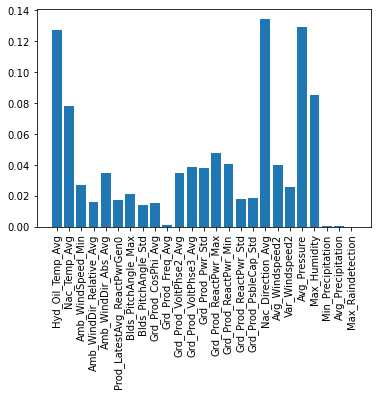

In [33]:
plt.xticks(rotation=90)
plt.bar(best_data.columns, my_clf["dt"].feature_importances_)

In [34]:
actual.to_list().count(1)

0

(array([ 8487.,     0., 10500.,     0.,     0.,  9316.,     0., 10001.,
            0., 10406.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

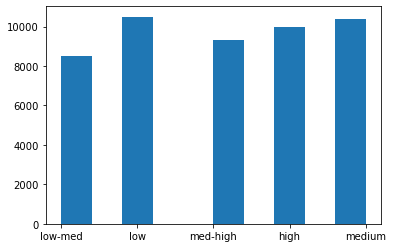

In [35]:
plt.hist(y_train, bins=10)

(array([ 5545.,     0.,  5131.,     0.,     0.,  3240.,     0.,  5169.,
            0., 12346.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

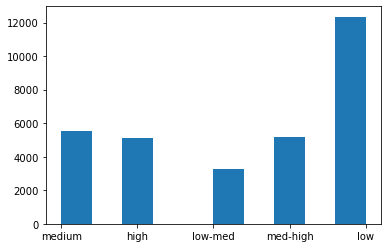

In [36]:
plt.hist(prediction, bins=10)

In [37]:
drop_cols.remove("Unnamed: 0")
drop_cols.remove("Unnamed: 0.1")
drop_cols.remove("index_y")
train_out = train[drop_cols + best_data.columns.to_list()]
test_out = test[drop_cols + best_data.columns.to_list()]

In [38]:
train_out.head()

,Risk Level,Turbine_ID,Timestamp,Hyd_Oil_Temp_Avg,Nac_Temp_Avg,Amb_WindSpeed_Min,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,Prod_LatestAvg_ReactPwrGen0,Blds_PitchAngle_Max,...,Grd_Prod_ReactPwr_Std,Grd_Prod_PsbleCap_Std,Nac_Direction_Avg,Avg_Windspeed2,Var_Windspeed2,Avg_Pressure,Max_Humidity,Min_Precipitation,Avg_Precipitation,Max_Raindetection
0,low-med,T11,2016-09-16T23:10:00+00:00,36,29,2.7,-4.9,107.3,0,1.9,...,270.4,79.9,112.3,3.7,0.13,1012.0,49.0,0.0,0.0,0.0
1,low,T01,2016-05-26T16:20:00+00:00,31,31,1.0,-2.4,295.7,0,0.6,...,6.8,107.6,298.1,6.6,0.64,1006.0,54.0,0.0,0.0,0.0
2,low-med,T11,2016-09-05T01:40:00+00:00,41,38,2.9,-4.7,82.3,0,-0.8,...,7.8,1.5,87.0,8.1,0.25,1011.0,27.0,0.0,0.0,0.0
3,med-high,T11,2016-07-14T12:50:00+00:00,49,38,1.2,-25.6,72.0,0,14.9,...,3.7,105.7,97.5,16.1,2.16,1010.0,67.0,0.0,0.0,0.0
4,med-high,T07,2017-03-08T12:10:00+00:00,32,30,2.7,-17.3,72.7,0,-1.3,...,7.1,0.0,90.1,5.6,0.44,1009.0,72.0,0.0,0.0,0.0


In [39]:
check_df = test_out.sort_values(by="Timestamp")

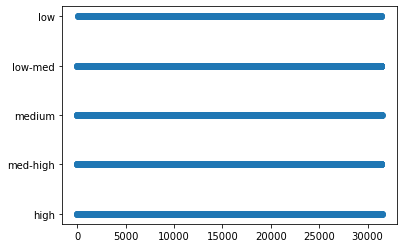

In [40]:
machine06 = check_df[check_df["Turbine_ID"] == "T06"]
plt.scatter(machine06.index, machine06[class_target_name])

(<Figure size 432x288 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.19607843137254902, 0.29269602577873255),
  ('0', '1'): (0.0,
   0.2959854994629431,
   0.19607843137254902,
   0.2973952738990334),
  ('0', '2'): (0.0,
   0.5966702470461871,
   0.19607843137254902,
   0.04766380236305048),
  ('0', '3'): (0.0,
   0.6476235230934481,
   0.19607843137254902,
   0.16011009667024712),
  ('0', '4'): (0.0,
   0.8110230934479057,
   0.19607843137254902,
   0.18897690655209443),
  ('1', '0'): (0.20098039215686275,
   0.0,
   0.19607843137254902,
   0.1164333295698318),
  ('1', '1'): (0.20098039215686275,
   0.11972280325404232,
   0.19607843137254902,
   0.4568197619486224),
  ('1', '2'): (0.20098039215686275,
   0.5798320388868753,
   0.19607843137254902,
   0.13782586476352335),
  ('1', '3'): (0.20098039215686275,
   0.7209473773346091,
   0.19607843137254902,
   0.12668391935014228),
  ('1', '4'): (0.20098039215686275,
   0.8509207703689619,
   0.19607843137254902,
   0.1490792296310382),
  ('2'

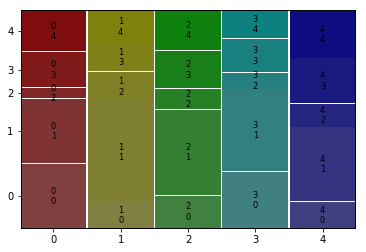

In [43]:
from sklearn.metrics import confusion_matrix
from statsmodels.graphics.mosaicplot import mosaic
cm = confusion_matrix(actual, prediction, normalize='true')
props = lambda key: {'color': 'y' if "0" in key else 'gray'}
# label_dict = {"0": 'high', "1": 'low', "2": 'low-med', "3": 'med-high', "4": 'medium'}
# labelizer = lambda k: {("0",): label_dict["0"], ("1",): label_dict["1"], ("2",): label_dict["2"], ("3",): label_dict["3"], ("4",): label_dict["4"]}[k]
mosaic(cm)

In [44]:
import os
os.makedirs("./data/feature_selected", exist_ok=True)

In [45]:
train_out.to_csv("./data/feature_selected/train_hydraulic_multi.csv")
test_out.to_csv("./data/feature_selected/test_hydraulic_multi.csv")

In [46]:
import pickle

In [47]:
os.makedirs("./model/feature_selected", exist_ok=True)

In [48]:
with open('./model/feature_selected/model.pickle', 'wb') as handle:
    handle.write(pickle.dumps(my_clf))